# 实验四：基于自动编码器的手写数字生成

In [71]:
import sys,os
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))) # 添加上层目录到 sys.path

from data_process import X_test,X_train,X_valid,y_test_master
from data_process import y_test,y_train,y_train_master,y_valid_master,y_valid
from data_process import X_valid_MCI,X_train_MCI,y_valid_MCI,y_train_MCI
# from dimension_reduction import X_train,X_valid,X_test
from dimension_reduction_lda import dimension_reduction,visualization
from train_and_test import train_and_test,device
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [72]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train_master = torch.from_numpy(y_train_master).float()
y_test_master = torch.from_numpy(y_test_master).float()

train_dataset = torch.utils.data.TensorDataset(X_train,y_train_master)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test_master)

In [73]:
print(X_train.shape)
print(X_test.shape)
print(y_train_master.shape)
print(y_test_master.shape)

X_train=X_train/100
print(X_train)

torch.Size([178, 186])
torch.Size([63, 186])
torch.Size([178])
torch.Size([63])
tensor([[-0.0049,  0.0182, -0.0015,  ..., -0.0064,  0.0064,  0.0002],
        [-0.0094,  0.0010, -0.0015,  ...,  0.0125,  0.0084,  0.0140],
        [ 0.0056, -0.0042, -0.0015,  ..., -0.0037, -0.0083, -0.0024],
        ...,
        [-0.0143,  0.0021, -0.0015,  ..., -0.0079,  0.0022, -0.0076],
        [-0.0015, -0.0004, -0.0015,  ...,  0.0031,  0.0182, -0.0137],
        [ 0.0053, -0.0099, -0.0015,  ...,  0.0102,  0.0114,  0.0061]])


In [74]:
# Encoder
class Encoder(nn.Module):
    """ Vanilla encoder with 3 fc layers 
    Args:
            dIn (int): Dim of input, if `x.shape = [N, C, H, W]`, then `dIn = C*H*W`
        dHidden (int): Dim of intermediate FCs.
             dZ (int): Dim of z.
             
    Inputs:
        x (torch.FloatTensor): [N, 1, 28, 28]. Input images.
        
    Outputs:
        torch.FloatTensor: [N, dZ]. Latent variable z.
    """
    def __init__(self, dIn: int, dHidden: int, dZ: int):
        super().__init__()
        # [fc -> relu -> bn] * 2 -> fc 
        self._net = nn.Sequential(
            nn.Linear(dIn, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, dZ)
        )
        
    def forward(self, x):
        return self._net(x)

In [75]:
# Encoder
class Decoder(nn.Module):
    """ Vanilla decoder with 3 fc layers 
    Args:
             dZ (int): Dim of z.
        dHidden (int): Dim of intermediate FCs.
             hw (int): Height/width of x.
        channel (int): Channel num of x.
             
    Inputs:
        z (torch.FloatTensor): [N, dZ]. Input latent variable z.
        
    Outputs:
        torch.FloatTensor: [N, channel, hw, hw]. xHat, restored x.
    """
    def __init__(self, dZ: int, dHidden: int, dOut:int):
        super().__init__()
        # [fc -> relu -> bn] * 2 -> fc 
        self._net = nn.Sequential(
            nn.Linear(dZ, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, dHidden),
            nn.ReLU(),
            nn.BatchNorm1d(dHidden),
            nn.Linear(dHidden, dOut),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        return self._net(z)

In [76]:
lossFn = F.binary_cross_entropy
# lossFn = F.mse_loss

In [77]:
############### FOR TRAINING, DO NOT CHANGE ###############
def train(encoder: nn.Module, decoder: nn.Module, trainDataset, testDataset, lossFn, lr = 0.001, step = 1000):
    ############### FOR VISUALIZATION, DO NOT CHANGE ###############
    def visualize(encoder: nn.Module, decoder: nn.Module, losses: [float]):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(losses)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.set_title("Loss Over Iterations")
        plt.grid(True)
        plt.show()
    # create Dataset loader
    loader = torch.utils.data.DataLoader(trainDataset, batch_size=2, shuffle=True, num_workers=2)
    # create Optimizer
    optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr)
    
    # loss logging
    losses = list()
    iterator = iter(loader)
    
    for i in range(step):
        try:
            x, _ = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            x, _ = next(iterator)
        # encoding
        z = encoder(x)
        # decoding
        xHat = decoder(z)
        # compute reconstruction loss
        loss = lossFn(xHat, x)
        # log losses
        losses.append(loss.item())
        if loss.requires_grad == False:
            loss.requires_grad = True

        # gradient backward and step
        optimizer.zero_grad(None)
        loss.backward()
        optimizer.step()

        # visualize
        if i % 100 == 0:
            torch.set_grad_enabled(False)
            encoder.eval()
            decoder.eval()
            visualize(encoder, decoder, losses)
            encoder.train()
            decoder.train()
            torch.set_grad_enabled(True)
    # final
    print(f"Train on {step} steps finished.")
    print(f"Final loss: {loss.item()}")

In [78]:
# H=[150,100]
H=100
dim=60
encoder, decoder = Encoder(X_train.shape[1], H, dim), Decoder(dim, H, X_train.shape[1])
for name, param in encoder.named_parameters():
    print(f"Parameter: {name}, requires_grad: {param.requires_grad}")
for name, param in decoder.named_parameters():
    print(f"Parameter: {name}, requires_grad: {param.requires_grad}")
# Encoder = Encoder(1, cHidden, cZ)
x = torch.rand(2, 186)
z = encoder(x)
print("Shape of \"z\":", list(z.shape))

# Decoder = Decoder(cZ, cHidden, 1)
xHat = decoder(z)
print("Shape of \"xHat\":", list(xHat.shape))
if xHat.shape != x.shape:
    raise ValueError("Oops! x and xHat don't have same shape")
else:
    print("Alright!")

Parameter: _net.0.weight, requires_grad: True
Parameter: _net.0.bias, requires_grad: True
Parameter: _net.2.weight, requires_grad: True
Parameter: _net.2.bias, requires_grad: True
Parameter: _net.3.weight, requires_grad: True
Parameter: _net.3.bias, requires_grad: True
Parameter: _net.5.weight, requires_grad: True
Parameter: _net.5.bias, requires_grad: True
Parameter: _net.6.weight, requires_grad: True
Parameter: _net.6.bias, requires_grad: True
Parameter: _net.0.weight, requires_grad: True
Parameter: _net.0.bias, requires_grad: True
Parameter: _net.2.weight, requires_grad: True
Parameter: _net.2.bias, requires_grad: True
Parameter: _net.3.weight, requires_grad: True
Parameter: _net.3.bias, requires_grad: True
Parameter: _net.5.weight, requires_grad: True
Parameter: _net.5.bias, requires_grad: True
Parameter: _net.6.weight, requires_grad: True
Parameter: _net.6.bias, requires_grad: True
Shape of "z": [2, 60]
Shape of "xHat": [2, 186]
Alright!


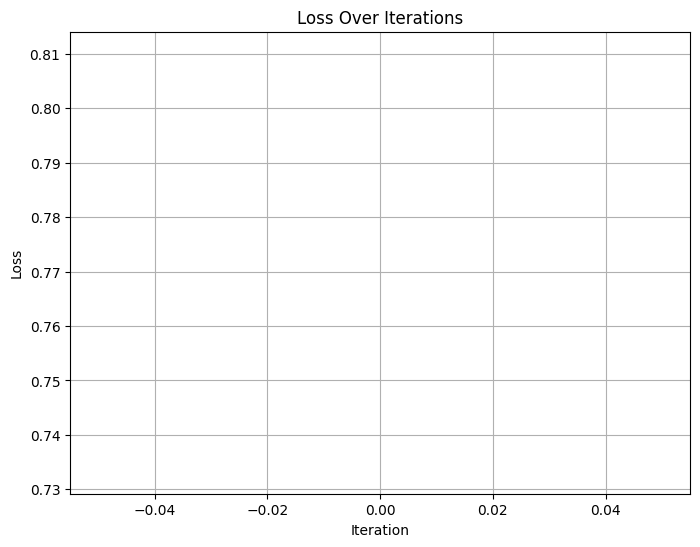

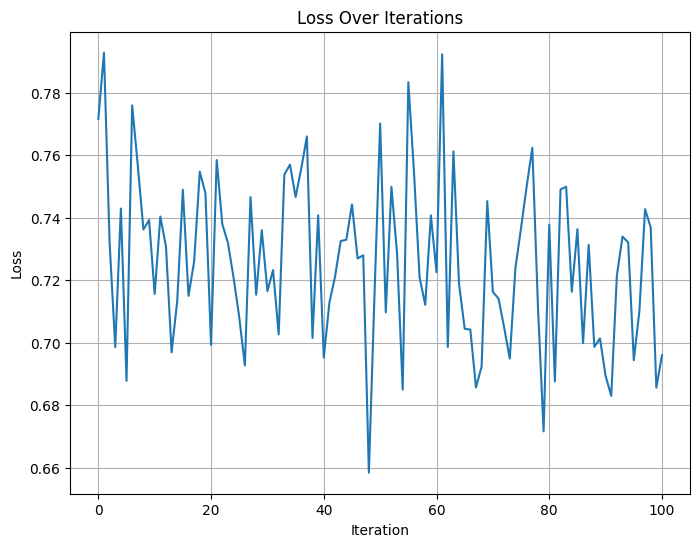

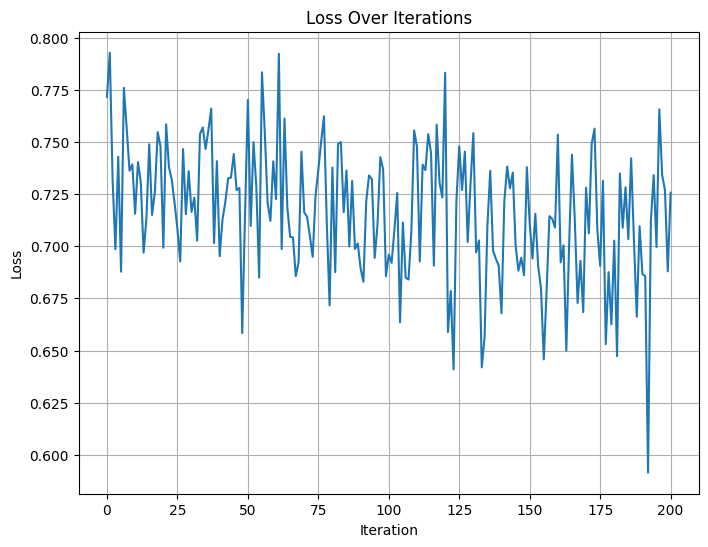

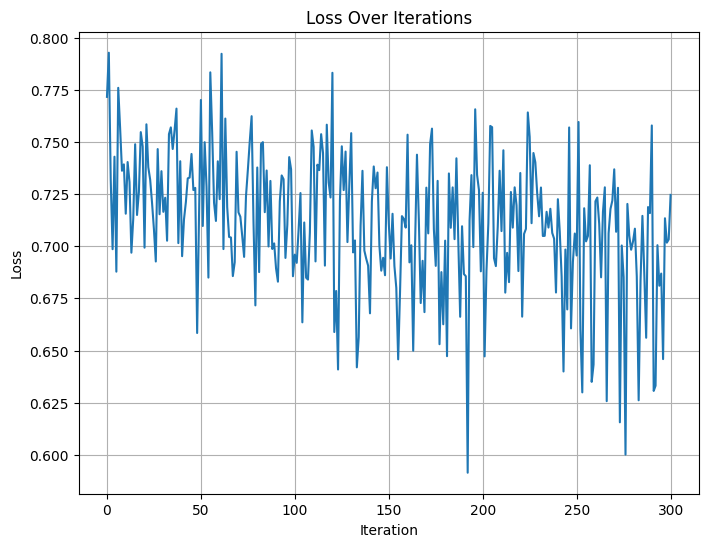

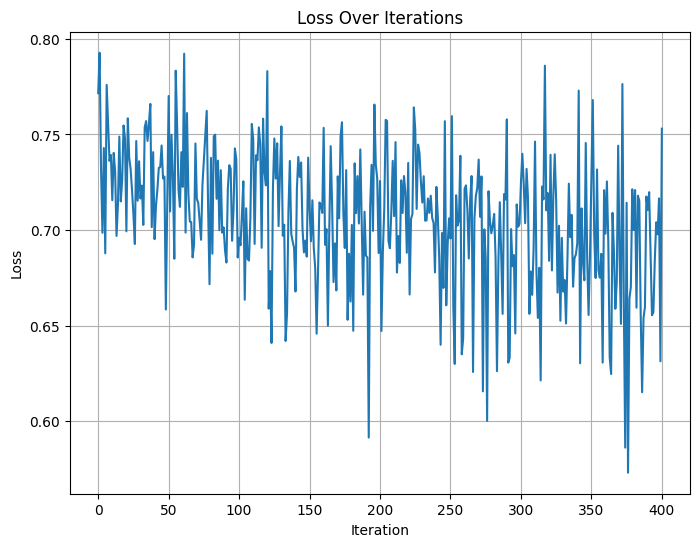

Train on 500 steps finished.
Final loss: 0.5994147658348083


In [79]:
# use `F.binary_cross_entropy` as loss function, learning rate = 0.0005, train steps = 6000
train(encoder, decoder, train_dataset, test_dataset, lossFn, lr=0.0001, step=500)